In [2]:
# Пути к данным
DATA_PATH = "mall_customers.csv"

# Настройки предобработки
TEST_SIZE = 0.2
RANDOM_STATE = 42

# Настройки моделирования
N_CLUSTERS_RANGE = range(2, 8)

# Настройки аномалий
ANOMALY_CONTAMINATION = 0.1

# Настройки для датасета
FEATURE_COLUMNS = [
  "Age",
  "Annual_Income_(k$)",
  "Spending_Score_(1-100)",
]  # Основные признаки для анализа


In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

"""Загрузка и описания данных"""
def load_data():
        """
        Загрузка данных и возвращение DataFrame с описанием
        """
        print("Загрузка данных...")
        try:
            df = pd.read_csv(DATA_PATH)
            print("Данные загружены.")

            # Описание колонок
            column_descriptions = {
                "CustomerID": "Уникальный идентификатор клиента",
                "Gender": "Пол клиента (Male/Female)",
                "Age": "Возраст клиента",
                "Annual_Income_(k$)": "Годовой доход в тысячах долларов",
                "Spending_Score_(1-100)": "Оценка расходов (1-100), присвоенная торговым центром",
            }

            return df, column_descriptions
        except Exception as e:
            print(f"Ошибка загрузки CSV {DATA_PATH}: {e}")
            raise

def describe_dataset(df: pd.DataFrame, descriptions: dict):
    """Подробное описание датасета"""
    print("\n" + "=" * 60)
    print("ОПИСАНИЕ ДАТАСЕТА MALL CUSTOMERS")
    print("=" * 60)

    print(f"Размер данных: {df.shape[0]} строк, {df.shape[1]} колонок")

    print("\nОписание колонок:")
    for col, desc in descriptions.items():
        if col in df.columns:
            print(f" • {col}: {desc}")

    print("\nТипы данных:")
    print(df.dtypes)

    print("\nCтатистика числовых признаков:")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    print(df[numeric_cols].describe())

    print("\nСтатистика категориальных признаков:")
    categorical_cols = df.select_dtypes(include=["object"]).columns
    # print(df[categorical_cols].describe())
    for col in categorical_cols:
        print(f"\n{col}:")
        print(df[col].value_counts())

# 1. Загрузка датасета
df, column_descriptions = load_data()
describe_dataset(df, column_descriptions)

Загрузка данных...
Данные загружены.

ОПИСАНИЕ ДАТАСЕТА MALL CUSTOMERS
Размер данных: 200 строк, 5 колонок

Описание колонок:
 • CustomerID: Уникальный идентификатор клиента
 • Gender: Пол клиента (Male/Female)
 • Age: Возраст клиента
 • Annual_Income_(k$): Годовой доход в тысячах долларов
 • Spending_Score_(1-100): Оценка расходов (1-100), присвоенная торговым центром

Типы данных:
CustomerID                 int64
Gender                    object
Age                        int64
Annual_Income_(k$)         int64
Spending_Score_(1-100)     int64
dtype: object

Cтатистика числовых признаков:
       CustomerID         Age  Annual_Income_(k$)  Spending_Score_(1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000    

In [4]:
# Удаление CustomerID
df.drop(df.columns[0] ,axis=1 ,inplace=True)
(df.head())

,Gender,Age,Annual_Income_(k$),Spending_Score_(1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [5]:
"""Проверка качества данных"""
print("\n" + "=" * 50)
print("ПРОВЕРКА КАЧЕСТВА ДАННЫХ")
print("=" * 50)

quality_report = {}

# Пропущенные значения
missing_data = df.isnull().sum()
quality_report["missing_values"] = missing_data[missing_data > 0]

# Дубликаты
duplicates = df.duplicated().sum()
quality_report["duplicates"] = duplicates

# Выбросы (используем IQR метод)
numerical_cols = df.select_dtypes(include=[np.number]).columns
numerical_cols = [
    col for col in numerical_cols
]  # Исключаем ID

outliers_report = {}
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    outliers_report[col] = {
        "count": outliers,
        "lower_bound": lower_bound,
        "upper_bound": upper_bound,
    }

quality_report["outliers"] = outliers_report

# Вывод отчета
print("Пропущенные значения:")
missing_exists = False
for col, count in quality_report["missing_values"].items():
    print(f" • {col}: {count} пропусков")
    missing_exists = True
if not missing_exists:
    print("Пропущенных значений нет")

print(f"\nДубликаты: {quality_report['duplicates']}")

print("\nВыбросы (IQR метод):")
for col, info in quality_report["outliers"].items():
    print(
        f" • {col}: {info['count']} выбросов "
        f"(границы: [{info['lower_bound']:.2f}, {info['upper_bound']:.2f}])"
    )


ПРОВЕРКА КАЧЕСТВА ДАННЫХ
Пропущенные значения:
Пропущенных значений нет

Дубликаты: 0

Выбросы (IQR метод):
 • Age: 0 выбросов (границы: [-1.62, 79.38])
 • Annual_Income_(k$): 2 выбросов (границы: [-13.25, 132.75])
 • Spending_Score_(1-100): 0 выбросов (границы: [-22.62, 130.38])



Визуализация распределений...


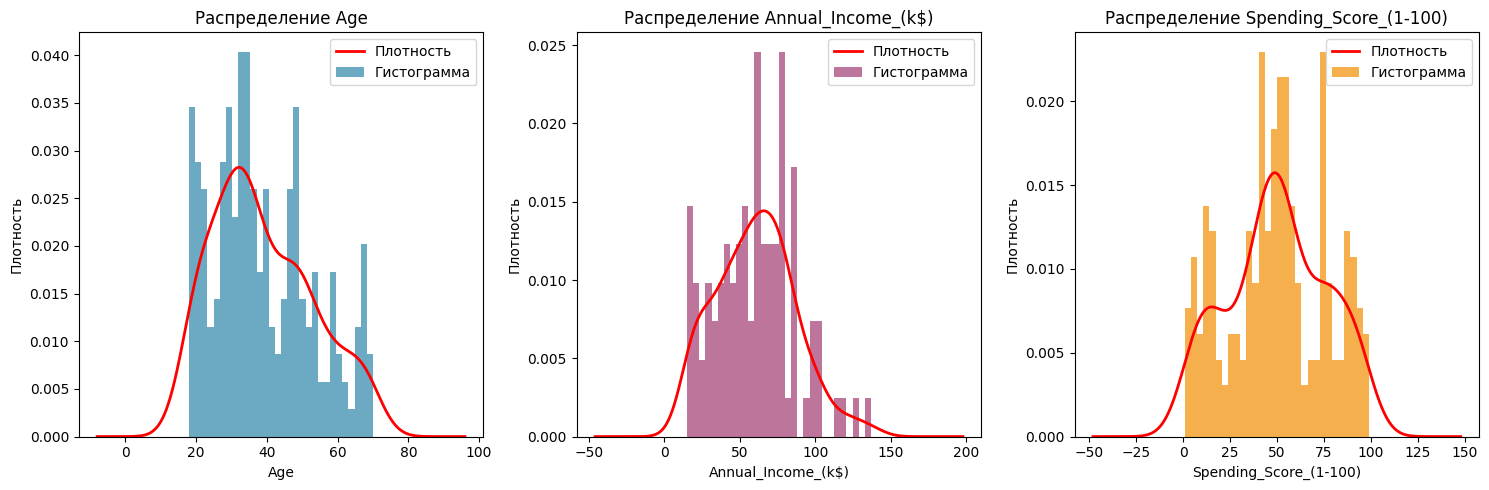

,count
Gender,
Female,112
Male,88


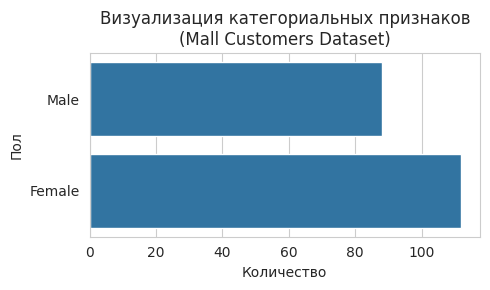

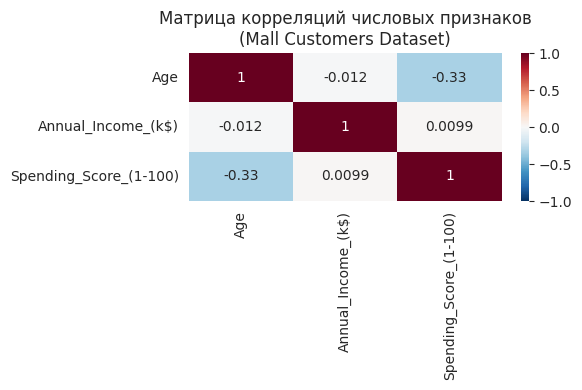

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

"""Визуализация распределений датасета"""
print("\nВизуализация распределений...")

plt.style.use("default")
colors = ["#2E86AB", "#A23B72", "#F18F01", "#C73E1D", "#3B1F2B"]


# Исключаем CustomerID из анализа
numerical_cols = df.select_dtypes(include=[np.number]).columns
numerical_cols = [col for col in numerical_cols]

n_cols = min(3, len(numerical_cols))
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

if n_rows == 1:
  axes = [axes] if n_cols == 1 else axes
else:
  axes = axes.flatten()

for i, col in enumerate(numerical_cols):
  if i < len(axes):
      # Гистограмма с KDE
      ax_hist = axes[i]
      df[col].hist(
          bins=30,
          ax=ax_hist,
          color=colors[i % len(colors)],
          alpha=0.7,
          density=True,
      )
      df[col].plot.density(ax=ax_hist, color="red", linewidth=2)
      ax_hist.set_title(f"Распределение {col}")
      ax_hist.set_xlabel(col)
      ax_hist.set_ylabel("Плотность")
      ax_hist.legend(["Плотность", "Гистограмма"])

# Скрываем пустые subplots
for i in range(len(numerical_cols), len(axes)):
  axes[i].set_visible(False)

plt.tight_layout()
plt.show()

"""Визуализация категориальных признаков"""
plt.figure(figsize=(5, 3))
sns.set_style("whitegrid")
plot = sns.countplot(df['Gender'])
display(df['Gender'].value_counts())
plt.xlabel('Количество')
plt.ylabel('Пол')
plt.title("Визуализация категориальных признаков\n(Mall Customers Dataset)")
plt.tight_layout()
plt.show()

"""Матрица корреляций датасета"""
numerical_df = df.select_dtypes(include=[np.number])
numerical_df = numerical_df.drop("CustomerID", axis=1, errors="ignore")
plt.figure(figsize=(6, 4))
sns.heatmap(
    numerical_df.corr(),
    cmap='RdBu_r', # задаёт цветовую схему
    annot=True, # рисует значения внутри ячеек
    vmin=-1, vmax=1);
plt.title("Матрица корреляций числовых признаков\n(Mall Customers Dataset)")
plt.tight_layout()
plt.show()


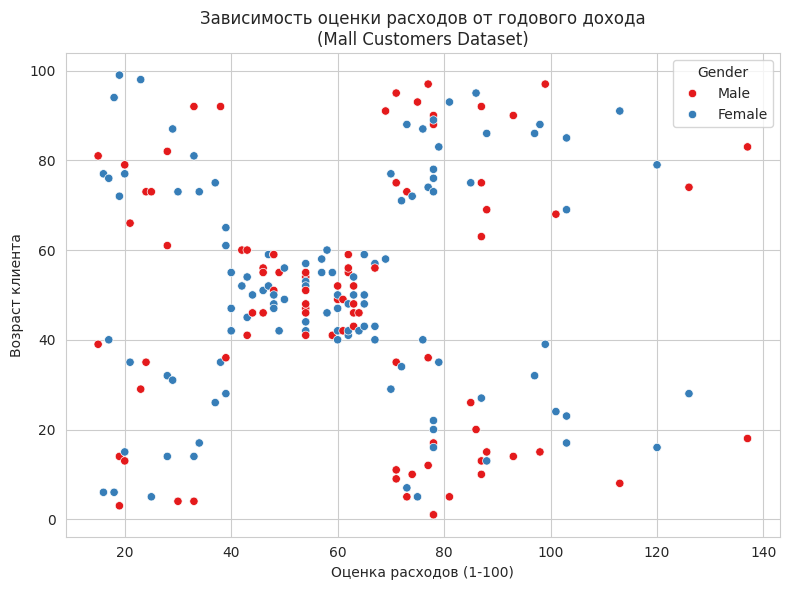

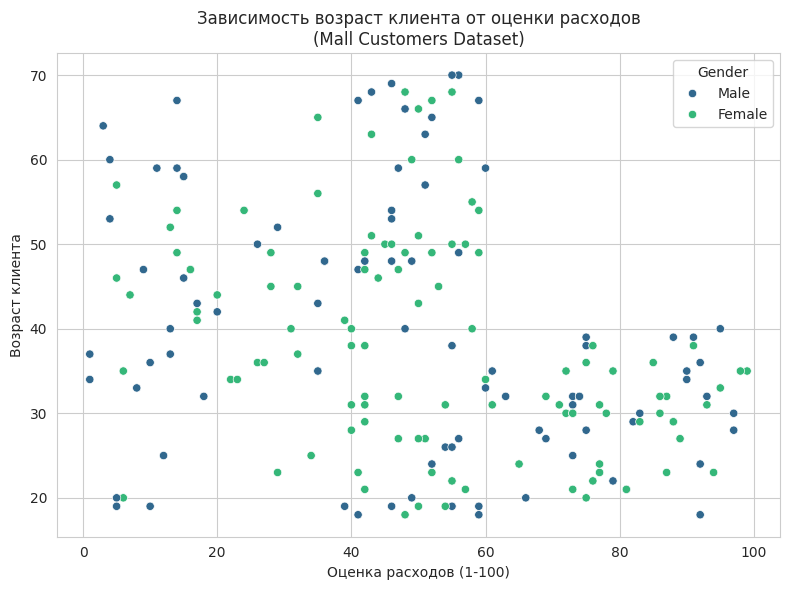

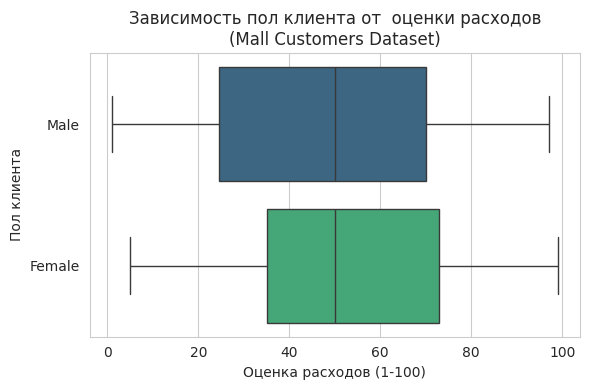

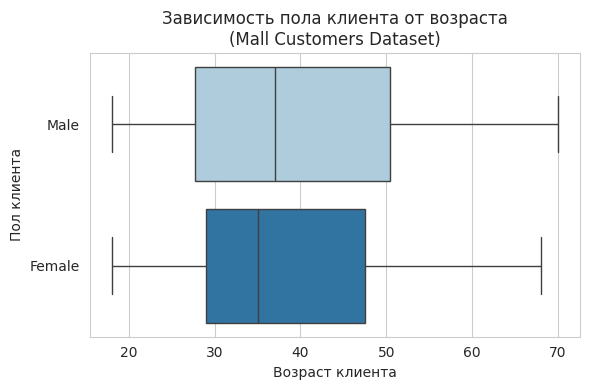

In [7]:
"""Графики для анализа зависимостей"""

plt.figure(figsize=(8,6),dpi=100)
sns.scatterplot(data=df, x='Annual_Income_(k$)', y='Spending_Score_(1-100)', hue='Gender', palette='Set1');
plt.xlabel('Оценка расходов (1-100)')
plt.ylabel('Возраст клиента')
plt.title("Зависимость оценки расходов от годового дохода\n(Mall Customers Dataset)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6),dpi=100)
sns.scatterplot(data=df, x='Spending_Score_(1-100)', y='Age', hue='Gender', palette='viridis');
plt.xlabel('Оценка расходов (1-100)')
plt.ylabel('Возраст клиента')
plt.title("Зависимость возраст клиента от оценки расходов\n(Mall Customers Dataset)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4),dpi=100)
sns.boxplot(data=df, y='Gender', x='Spending_Score_(1-100)', palette='viridis');
plt.xlabel('Оценка расходов (1-100)')
plt.ylabel('Пол клиента')
plt.title("Зависимость пол клиента от  оценки расходов\n(Mall Customers Dataset)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4),dpi=100)
sns.boxplot(data=df, y='Gender', x='Age', palette='Paired');
plt.xlabel('Возраст клиента')
plt.ylabel('Пол клиента')
plt.title("Зависимость пола клиента от возраста\n(Mall Customers Dataset)")
plt.tight_layout()
plt.show()


In [8]:
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

print("\n" + "=" * 50)
print("ЗАПУСК ПРЕДОБРАБОТКИ ДАННЫХ")
print("=" * 50)
original_shape = df.shape
original_columns = df.columns.tolist()
# scaler = StandardScaler()

label_encoders = {}
imputer = None
feature_names = []

# 1. Обработка пропущенных значений
print("Пропущеных значений нет")

# 2. Кодирование категориальных признаков
numerical_cols = df.select_dtypes(include=[np.number]).columns
numeric_features = [col for col in numerical_cols]
categorical_cols = df.select_dtypes(include=["object"]).columns
categorical_features = [col for col in categorical_cols]

# Препроцессинг
preprocessor = ColumnTransformer(
  transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
  ])

# 3. Удаление выбросов
print("Обработка выбросов...")
"""Удаление выбросов с помощью IQR метода"""
# Используем информацию из quality_report об выбросах
if "outliers" in quality_report:
    outliers_indices = []

    for col, info in quality_report["outliers"].items():
        if col in df.columns and info["count"] > 0:
            lower_bound = info["lower_bound"]
            upper_bound = info["upper_bound"]

            col_outliers = df[
                (df[col] < lower_bound) | (df[col] > upper_bound)
            ].index
            outliers_indices.extend(col_outliers)

    # Удаляем только сильные выбросы, встречающиеся в нескольких признаках
    from collections import Counter

    outlier_counts = Counter(outliers_indices)
    strong_outliers = [
        idx for idx, count in outlier_counts.items() if count >= 2
    ]

    print(f"Удалено {len(strong_outliers)} выбросов")
    df = df.drop(strong_outliers)


ЗАПУСК ПРЕДОБРАБОТКИ ДАННЫХ
Пропущеных значений нет
Обработка выбросов...
Удалено 0 выбросов



ЗАДАЧА: СЕГМЕНТАЦИЯ КЛИЕНТОВ ТОРГОВОГО ЦЕНТРА

ОЦЕНКА МОДЕЛЕЙ КЛАСТЕРИЗАЦИИ
Number of clusters: 2, Silhouette Score: 0.30, Davies-Bouldin Index: 1.36, Inertia: 438.52, Calinski-Harabasz Index: 95.16
Number of clusters: 3, Silhouette Score: 0.31, Davies-Bouldin Index: 1.18, Inertia: 345.21, Calinski-Harabasz Index: 86.76
Number of clusters: 4, Silhouette Score: 0.35, Davies-Bouldin Index: 1.07, Inertia: 254.36, Calinski-Harabasz Index: 101.44
Number of clusters: 5, Silhouette Score: 0.35, Davies-Bouldin Index: 1.02, Inertia: 216.78, Calinski-Harabasz Index: 97.26
Number of clusters: 6, Silhouette Score: 0.36, Davies-Bouldin Index: 1.01, Inertia: 181.95, Calinski-Harabasz Index: 99.65
Number of clusters: 7, Silhouette Score: 0.33, Davies-Bouldin Index: 1.08, Inertia: 171.37, Calinski-Harabasz Index: 89.70


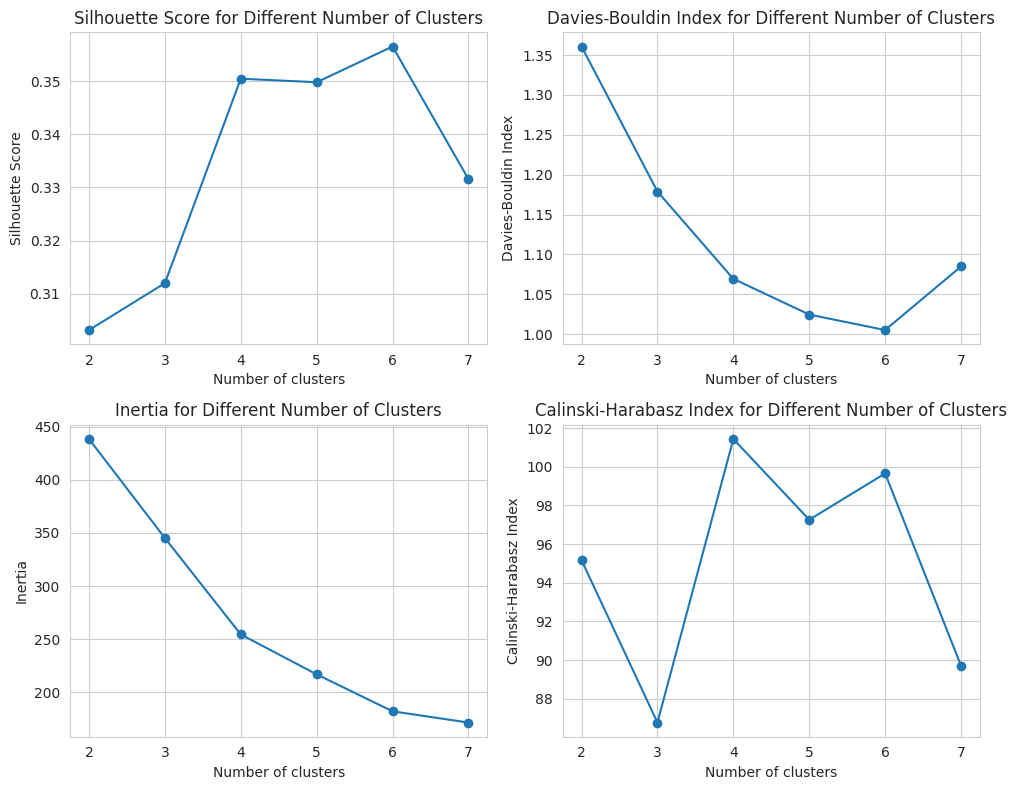

In [68]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


# 4. Кластеризация клиентов
print("\n" + "=" * 70)
print("ЗАДАЧА: СЕГМЕНТАЦИЯ КЛИЕНТОВ ТОРГОВОГО ЦЕНТРА")
print("=" * 70)
models = {}
results = {}
best_model = None
best_score = -1

print("\n" + "=" * 50)
print("ОЦЕНКА МОДЕЛЕЙ КЛАСТЕРИЗАЦИИ")
print("=" * 50)

# Списки для хранения значений метрик
silhouette_scores = []
davies_bouldin_scores = []
inertia_scores = []
calinski_harabasz_scores = []

# Проверка качества кластеризации для разного числа кластеров
for n_clusters in N_CLUSTERS_RANGE:
    # Создаем pipeline
    pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('cluster', KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE))
    ])
    # Применяем pipeline
    X_processed = preprocessor.fit_transform(df)
    clusters = pipeline.fit_predict(df)

    # Оценка метрик
    silhouette_avg = silhouette_score(X_processed, clusters)
    davies_bouldin = davies_bouldin_score(X_processed, clusters)
    inertia = pipeline['cluster'].inertia_
    calinski_harabasz = calinski_harabasz_score(X_processed, clusters)

    silhouette_scores.append(silhouette_avg)
    davies_bouldin_scores.append(davies_bouldin)
    inertia_scores.append(inertia)
    calinski_harabasz_scores.append(calinski_harabasz)

    print(f"Number of clusters: {n_clusters}, Silhouette Score: {silhouette_avg:.2f}, Davies-Bouldin Index: {davies_bouldin:.2f}, Inertia: {inertia:.2f}, Calinski-Harabasz Index: {calinski_harabasz:.2f}")


# Визуализация изменения метрик
plt.figure(figsize=(10, 8))

# Silhouette Score (Индекс Силуэт)
plt.subplot(2, 2, 1)
plt.plot(N_CLUSTERS_RANGE, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Number of Clusters')

# Davies-Bouldin Index (Индекс Дэвиса-Болдуина)
plt.subplot(2, 2, 2)
plt.plot(N_CLUSTERS_RANGE, davies_bouldin_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index for Different Number of Clusters')

# Inertia (Сумма внутрикластерных расстояний)
plt.subplot(2, 2, 3)
plt.plot(N_CLUSTERS_RANGE, inertia_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Inertia for Different Number of Clusters')

# Calinski-Harabasz Index (Коэффициент Кэллински-Харабаза)
plt.subplot(2, 2, 4)
plt.plot(N_CLUSTERS_RANGE, calinski_harabasz_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index for Different Number of Clusters')

plt.tight_layout()
plt.show()

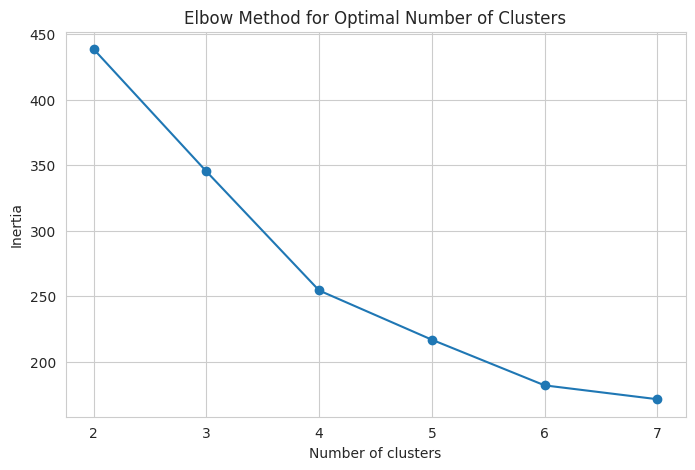

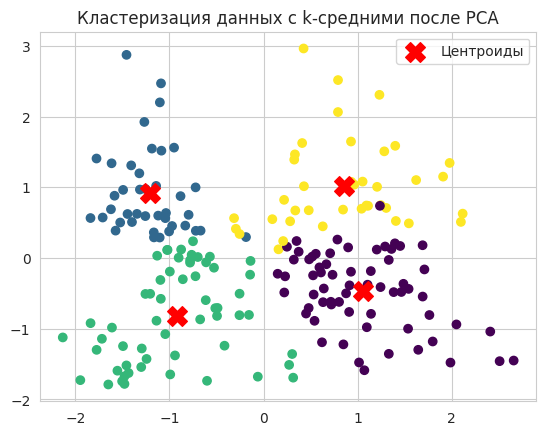

Силуэтовская оценка: 0.35
Индекс Дэвиса-Болдуина: 1.07
Индекс Калински-Харабаса: 101.44


In [71]:
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA

# # Метод локтя (Elbow Method) для выбора оптимального количества кластеров
inertia_scores = []
for n_clusters in N_CLUSTERS_RANGE:
    # Создаем pipeline
    pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('cluster', KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE))
    ])
    # Применяем pipeline
    X_processed = preprocessor.fit_transform(df)
    clusters = pipeline.fit_predict(df)
    inertia_scores.append(pipeline['cluster'].inertia_)

plt.figure(figsize=(8, 5))
plt.plot(N_CLUSTERS_RANGE, inertia_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()


# Выбор количества кластеров (k) на основе метода локтя
k = 4

# Кластеризация с использованием k-средних
# Создаем pipeline
pipeline = Pipeline([
('preprocessor', preprocessor),
('cluster', KMeans(n_clusters=k, random_state=RANDOM_STATE))
])
# Применяем pipeline
X_processed = preprocessor.fit_transform(df)
clusters = pipeline.fit_predict(df)

# Снижение размерности с использованием PCA для визуализации
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

# Преобразование центров кластеров с использованием PCA
centroids_pca = pca.transform(pipeline['cluster'].cluster_centers_)

# Визуализация кластеров после снижения размерности
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=200, c='red', label='Центроиды', marker='X')
plt.title('Кластеризация данных с k-средними после PCA')
plt.legend()
plt.show()


# Вычисление метрик качества
silhouette_avg = silhouette_score(X_processed, clusters)
davies_bouldin = davies_bouldin_score(X_processed, clusters)
calinski_harabasz = calinski_harabasz_score(X_processed, clusters)

print(f"Силуэтовская оценка: {silhouette_avg:.2f}")
print(f"Индекс Дэвиса-Болдуина: {davies_bouldin:.2f}")
print(f"Индекс Калински-Харабаса: {calinski_harabasz:.2f}")

Силуэтовская оценка: 0.35
Индекс Дэвиса-Болдуина: 1.01
Индекс Калински-Харабаса: 95.26


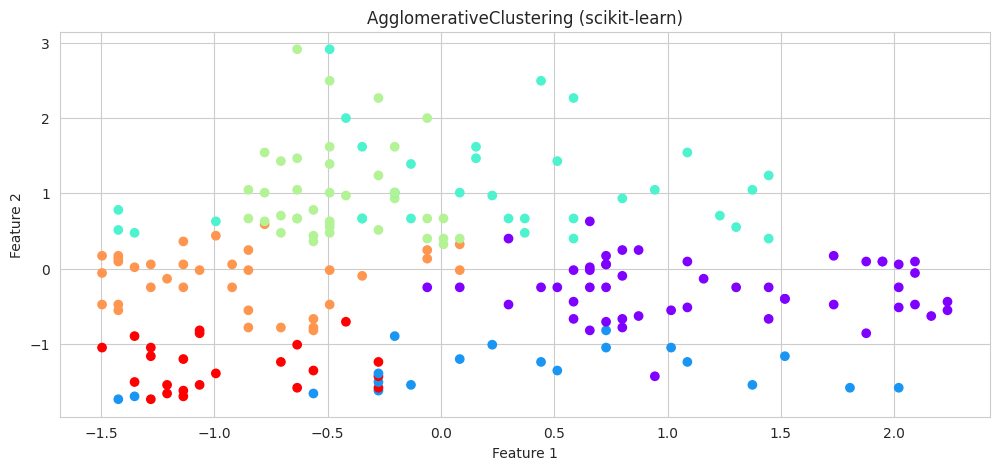

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import sqeuclidean
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Агломеративная кластеризация

X_processed = preprocessor.fit_transform(df)

sk_ac = AgglomerativeClustering(n_clusters=6, linkage='ward')
sk_ac_pred_res = sk_ac.fit_predict(X_processed)

# Вычисление метрик качества
silhouette_avg = silhouette_score(X_processed, sk_ac_pred_res)
davies_bouldin = davies_bouldin_score(X_processed, sk_ac_pred_res)
calinski_harabasz = calinski_harabasz_score(X_processed, sk_ac_pred_res)

print(f"Силуэтовская оценка: {silhouette_avg:.2f}")
print(f"Индекс Дэвиса-Болдуина: {davies_bouldin:.2f}")
print(f"Индекс Калински-Харабаса: {calinski_harabasz:.2f}")

plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 2)
plt.scatter(X_processed[:, 0],X_processed [:, 1], c=sk_ac_pred_res, cmap='rainbow')
plt.title('AgglomerativeClustering (scikit-learn)')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.show()

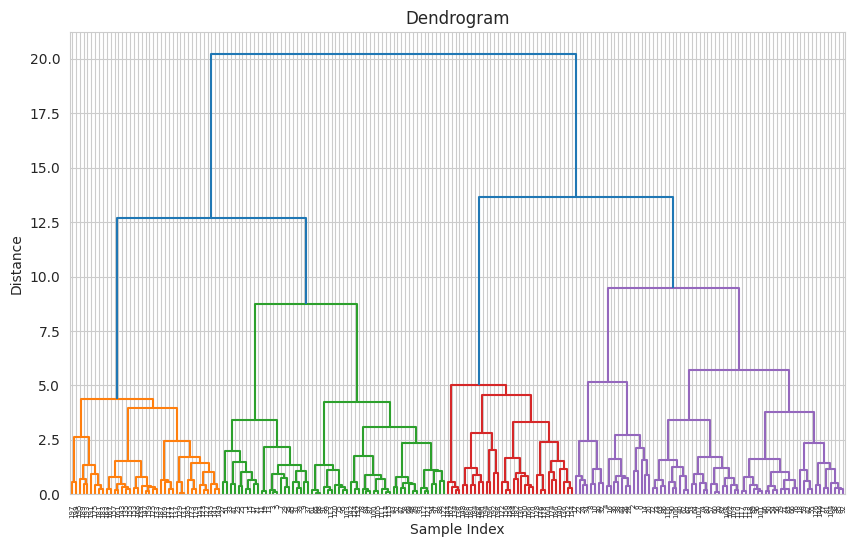

In [73]:
X_processed = preprocessor.fit_transform(df)
linkage_matrix = linkage(X_processed, method='ward', metric='euclidean')

# Визуализация дендрограммы
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, color_threshold=10)
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.title("Dendrogram")
plt.show()

Силуэтовская оценка: -0.21
Индекс Дэвиса-Болдуина: 1.73
Индекс Калински-Харабаса: 2.96


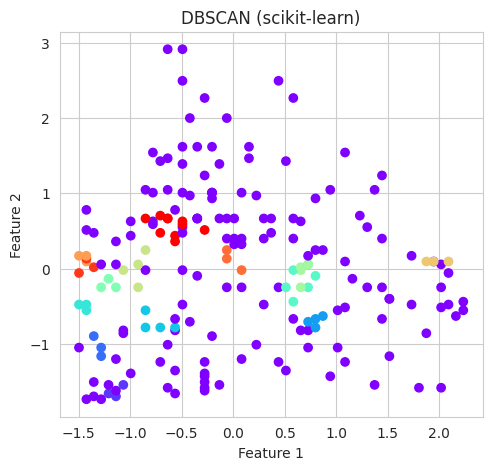

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Применение DBSCAN (Пространственная кластеризация на основе плотности)

X_processed = preprocessor.fit_transform(df)

dbscan = DBSCAN(eps=0.3, min_samples=3) #
predicted_labels = dbscan.fit_predict(X_processed)

# Вычисление метрик качества
silhouette_avg = silhouette_score(X_processed, predicted_labels)
davies_bouldin = davies_bouldin_score(X_processed, predicted_labels)
calinski_harabasz = calinski_harabasz_score(X_processed, predicted_labels)

print(f"Силуэтовская оценка: {silhouette_avg:.2f}")
print(f"Индекс Дэвиса-Болдуина: {davies_bouldin:.2f}")
print(f"Индекс Калински-Харабаса: {calinski_harabasz:.2f}")

# Визуализация кластеров
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.scatter(X_processed[:, 0],X_processed[:, 1], c=predicted_labels, cmap='rainbow')
plt.title('DBSCAN (scikit-learn)')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.show()

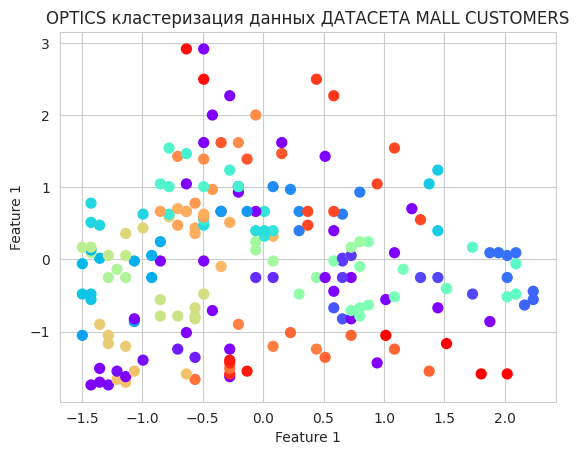

Силуэтовская оценка: 0.26
Индекс Дэвиса-Болдуина: 1.40
Индекс Калински-Харабаса: 11.27


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Кластеризация с использованием OPTICS
# Создаем pipeline
pipeline = Pipeline([
('preprocessor', preprocessor),
('cluster', OPTICS(min_samples=2))
])
# Применяем pipeline
X_processed = preprocessor.fit_transform(df)
clusters = pipeline.fit_predict(df)


# Визуализация кластеров (в этом случае, используем только первые два признака для визуализации)
plt.scatter(X_processed[:, 0], X_processed[:, 1], c=clusters, cmap='rainbow', s=50)
plt.title('OPTICS кластеризация данных ДАТАСЕТА MALL CUSTOMERS')
plt.xlabel("Feature 1")
plt.ylabel("Feature 1")
plt.show()

# Вычисление метрик качества
silhouette_avg = silhouette_score(X_processed, clusters)
davies_bouldin = davies_bouldin_score(X_processed, clusters)
calinski_harabasz = calinski_harabasz_score(X_processed, clusters)

print(f"Силуэтовская оценка: {silhouette_avg:.2f}")
print(f"Индекс Дэвиса-Болдуина: {davies_bouldin:.2f}")
print(f"Индекс Калински-Харабаса: {calinski_harabasz:.2f}")

Оценка силуэта: 0.3056
Количество кластеров: 6
Кластер 1 - Центр: [-0.99396865 -1.39547433  0.88513158  1.        ], Количество объектов: 26
Кластер 2 - Центр: [ 0.7284319  -0.82293289 -0.86183865  0.        ], Количество объектов: 35
Кластер 3 - Центр: [ 1.4460988  -0.25039146 -0.12422899  1.        ], Количество объектов: 32
Кластер 4 - Центр: [-0.85043527 -0.02137488 -0.00776431  0.        ], Количество объектов: 34
Кластер 5 - Центр: [ 0.22606507  0.97103028 -1.17241113  1.        ], Количество объектов: 34
Кластер 6 - Центр: [-0.6351352   1.04736914  1.38981187  0.        ], Количество объектов: 39


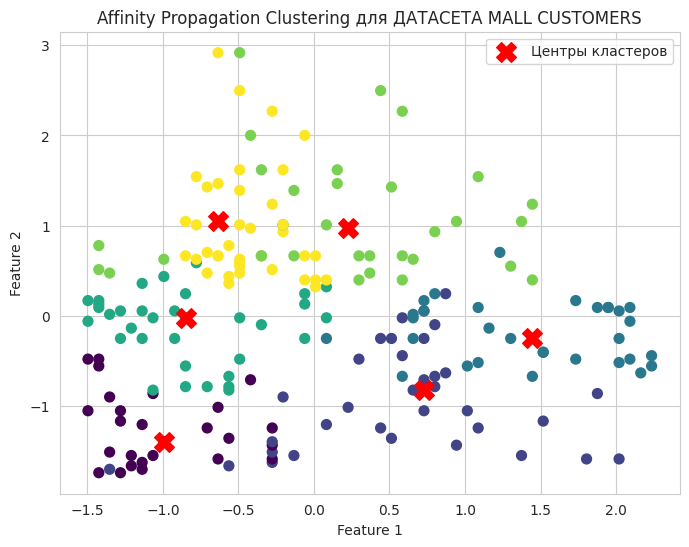

In [62]:
# Метод распространения близости.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AffinityPropagation
from sklearn import datasets
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from itertools import cycle
import seaborn as sns

X_processed = preprocessor.fit_transform(df)
af = AffinityPropagation(preference=-30, max_iter=50, damping=0.7,
                         random_state=42, convergence_iter=20).fit(X_processed)

# Получение кластеров и их центров
cluster_centers_indices = af.cluster_centers_indices_
cluster_labels = af.labels_

# Вывод результатов
silhouette_score = silhouette_score(X_processed, cluster_labels)
print(f"Оценка силуэта: {silhouette_score:.4f}")

# Вывод результатов
n_clusters_ = len(cluster_centers_indices)
print(f"Количество кластеров: {n_clusters_}")


for i in range(n_clusters_):
    cluster_center = X_processed[cluster_centers_indices[i]]
    cluster_objects = X_processed[cluster_labels == i]
    print(f"Кластер {i + 1} - Центр: {cluster_center}, Количество объектов: {len(cluster_objects)}")

# Визуализация кластеров с использованием первых двух признаков
plt.figure(figsize=(8, 6))
plt.scatter(X_processed[:, 0], X_processed[:, 1], c=cluster_labels, cmap='viridis', marker='o', s=50)
plt.scatter(X_processed[cluster_centers_indices, 0], X_processed[cluster_centers_indices, 1], c='red', marker='X', s=200, label='Центры кластеров')
plt.title('Affinity Propagation Clustering для ДАТАСЕТА MALL CUSTOMERS')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [78]:
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 15.4 MB/s eta 0:00:00



ЗАДАЧА: ПОИСК АНОМАЛЬНЫХ КЛИЕНТОВ


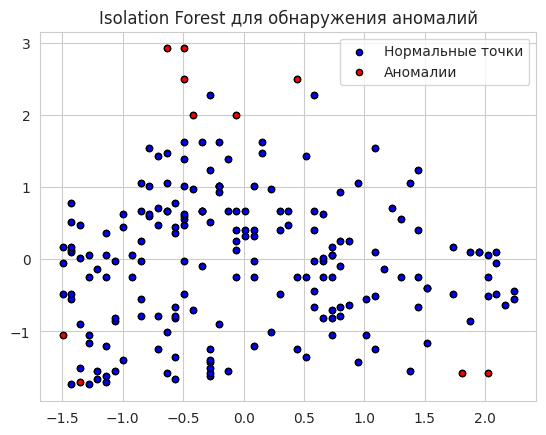

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns

#Поиск аномальных клиентов
print("\n" + "=" * 70)
print("ЗАДАЧА: ПОИСК АНОМАЛЬНЫХ КЛИЕНТОВ")
print("=" * 70)



X = preprocessor.fit_transform(df)
# Построение модели Isolation Forest
clf = IsolationForest(contamination=0.05, random_state=42, n_jobs=-1,)

clf.fit(X)
y_pred = clf.predict(X)

# Отображение результатов
plt.title("Isolation Forest для обнаружения аномалий")
plt.scatter(X[:, 0], X[:, 1], c='white', s=20, edgecolor='k')

# Отображение нормальных точек
normal_points = X[y_pred == 1]
plt.scatter(normal_points[:, 0], normal_points[:, 1], c='blue', s=20, edgecolor='k', label="Нормальные точки")

# Отображение аномалий
anomalies = X[y_pred == -1]
plt.scatter(anomalies[:, 0], anomalies[:, 1], c='red', s=20, edgecolor='k', label="Аномалии")

plt.legend()
plt.show()

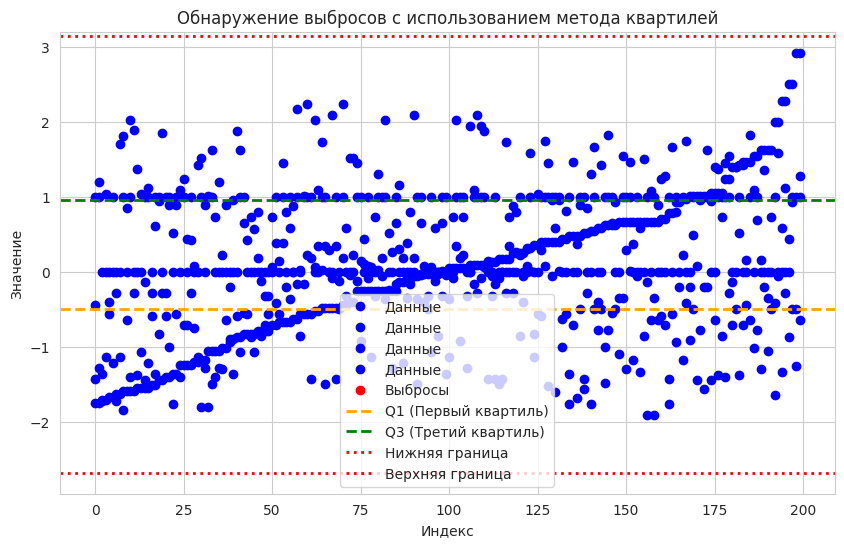

Найденные выбросы: []


In [80]:
import numpy as np
import matplotlib.pyplot as plt

data = preprocessor.fit_transform(df)

# Вычисление квартилей и межквартильного размаха
Q1 = np.percentile(data, 25)
Q3 = np.percentile(data, 75)
IQR = Q3 - Q1

# Определение границ для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Поиск выбросов
outliers = np.where((data < lower_bound) | (data > upper_bound))

# Визуализация данных и выбросов
plt.figure(figsize=(10, 6))
plt.plot(data, 'bo', label='Данные')
plt.plot(outliers[0], data[outliers], 'ro', label='Выбросы')
plt.axhline(Q1, color='orange', linestyle='dashed', linewidth=2, label='Q1 (Первый квартиль)')
plt.axhline(Q3, color='green', linestyle='dashed', linewidth=2, label='Q3 (Третий квартиль)')
plt.axhline(lower_bound, color='red', linestyle='dotted', linewidth=2, label='Нижняя граница')
plt.axhline(upper_bound, color='red', linestyle='dotted', linewidth=2, label='Верхняя граница')

plt.title('Обнаружение выбросов с использованием метода квартилей')
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.legend()
plt.show()

# Вывод найденных выбросов
print("Найденные выбросы:", data[outliers])

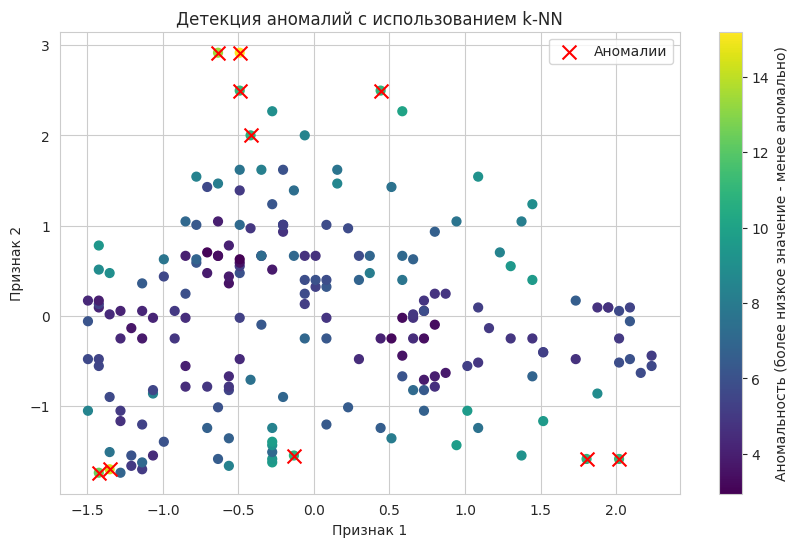

In [81]:
# knn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

data = preprocessor.fit_transform(df)

# Определяем число ближайших соседей (k)
k = 10

# Обучаем модель k-NN
knn = NearestNeighbors(n_neighbors=k)
knn.fit(data)

# Вычисляем расстояния и индексы k ближайших соседей для каждой точки
distances, indices = knn.kneighbors(data)

# Вычисляем метрику аномальности (количество соседей, находящихся на минимальном расстоянии)
anomaly_scores = np.sum(distances, axis=1)

# Определяем пороговое значение для определения аномалий (например, 95-й процентиль)
threshold = np.percentile(anomaly_scores, 95)

# Визуализируем данные
plt.figure(figsize=(10, 6))
plt.scatter(data[:, 0], data[:, 1], c=anomaly_scores, cmap='viridis', s=40)
plt.colorbar(label='Аномальность (более низкое значение - менее аномально)')
plt.title('Детекция аномалий с использованием k-NN')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')

# Выделяем аномальные точки
anomalies = data[anomaly_scores > threshold]
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='red', marker='x', s=100, label='Аномалии')
plt.legend()

plt.show()

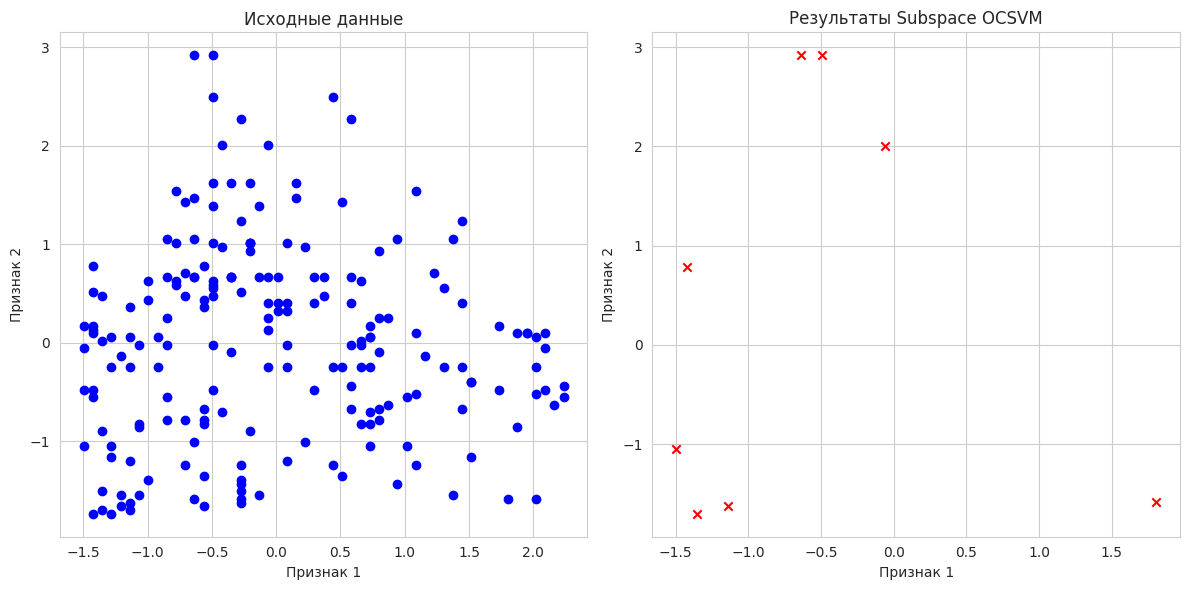

In [82]:
# svm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM

data = preprocessor.fit_transform(df)

# Обучаем Subspace OCSVM
clf = OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1)
clf.fit(data)

# Предсказываем аномалии
y_pred = clf.predict(data)

# Визуализируем данные и результаты
plt.figure(figsize=(12, 6))

# Визуализируем данные
plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], c='blue', marker='o', label='Данные')
plt.title('Исходные данные')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')

# Визуализируем аномалии (точки с отрицательным предсказанием)
plt.subplot(1, 2, 2)
plt.scatter(data[y_pred == -1][:, 0], data[y_pred == -1][:, 1], c='red', marker='x', label='Аномалии')
plt.title('Результаты Subspace OCSVM')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')

plt.tight_layout()
plt.show()

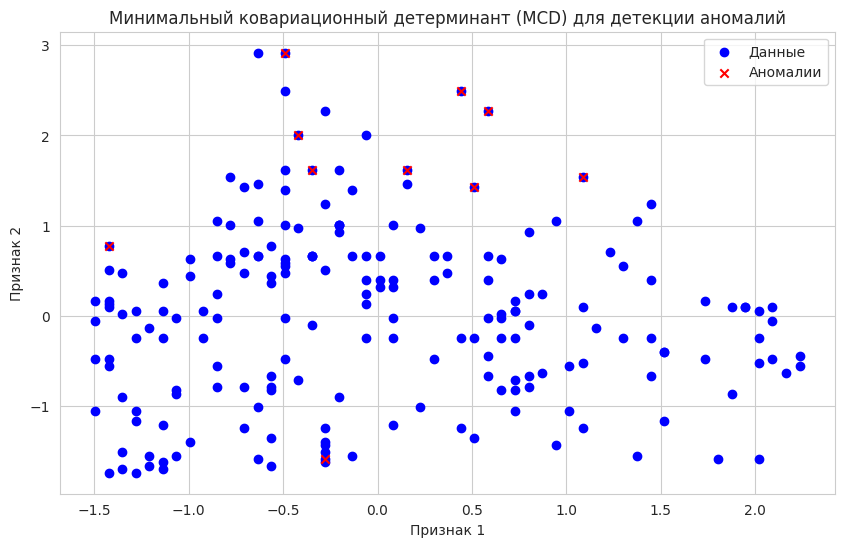

In [83]:
# Минимальный ковариационный детерминант
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import MinCovDet

data = preprocessor.fit_transform(df)

# Используем Минимальный ковариационный детерминант (MCD) для детекции аномалий
mcd = MinCovDet()
mcd.fit(data)

# Определение аномалий
mahal_dist = mcd.mahalanobis(data - mcd.location_)
threshold = np.percentile(mahal_dist, 95)  # Настройка порога для определения аномалий

# Визуализируем данные и аномалии
plt.figure(figsize=(10, 6))

# Визуализируем данные
plt.scatter(data[:, 0], data[:, 1], c='blue', marker='o', label='Данные')

# Визуализируем аномалии
plt.scatter(data[mahal_dist > threshold][:, 0], data[mahal_dist > threshold][:, 1], c='red', marker='x', label='Аномалии')

plt.title('Минимальный ковариационный детерминант (MCD) для детекции аномалий')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.legend()
plt.show()

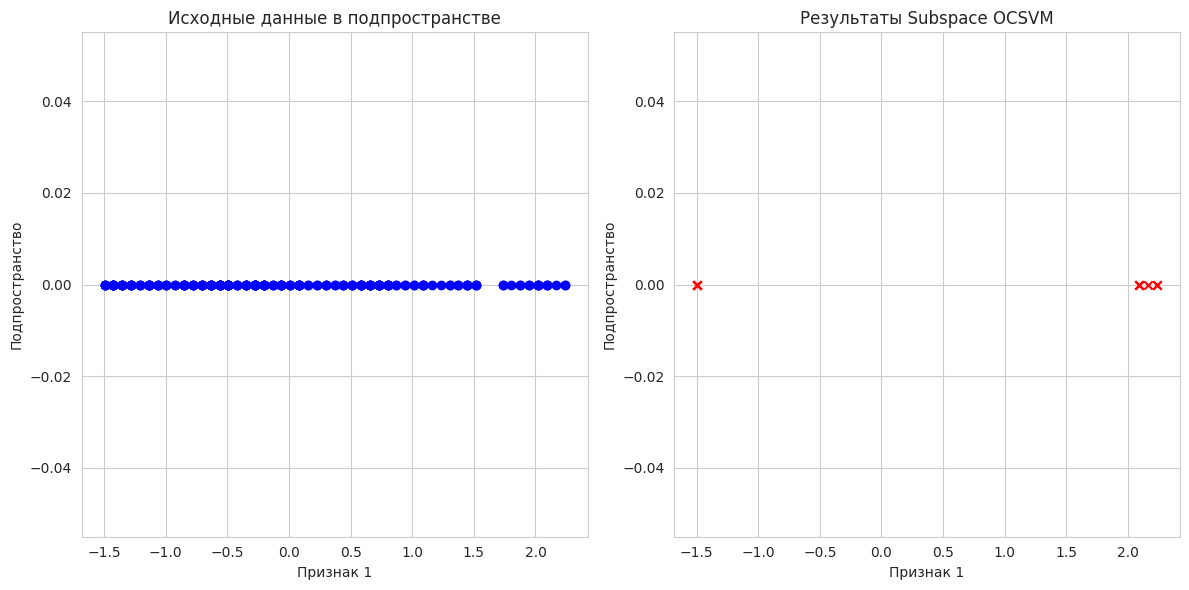

In [84]:
# Обнаружение выбросов в подпространстве

import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM

# Разбиваем данные на признаки
X = preprocessor.fit_transform(df)

# Обучение Subspace OCSVM
subspace_dim = 1  # Размерность подпространства
subspace_data = X[:, :subspace_dim]  # Выбор только первых subspace_dim признаков
ocsvm = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
ocsvm.fit(subspace_data)

# Предсказываем аномалии в подпространстве
y_pred_subspace = ocsvm.predict(subspace_data)

# Визуализируем данные и аномалии
plt.figure(figsize=(12, 6))

# Визуализируем данные
plt.subplot(1, 2, 1)
plt.scatter(subspace_data[:, 0], np.zeros_like(subspace_data[:, 0]), c='blue', marker='o', label='Данные')
plt.title('Исходные данные в подпространстве')
plt.xlabel('Признак 1')
plt.ylabel('Подпространство')

# Визуализируем аномалии в подпространстве
plt.subplot(1, 2, 2)
plt.scatter(subspace_data[y_pred_subspace == -1][:, 0], np.zeros_like(subspace_data[y_pred_subspace == -1][:, 0]),
            c='red', marker='x', label='Аномалии')
plt.title('Результаты Subspace OCSVM')
plt.xlabel('Признак 1')
plt.ylabel('Подпространство')

plt.tight_layout()
plt.show()

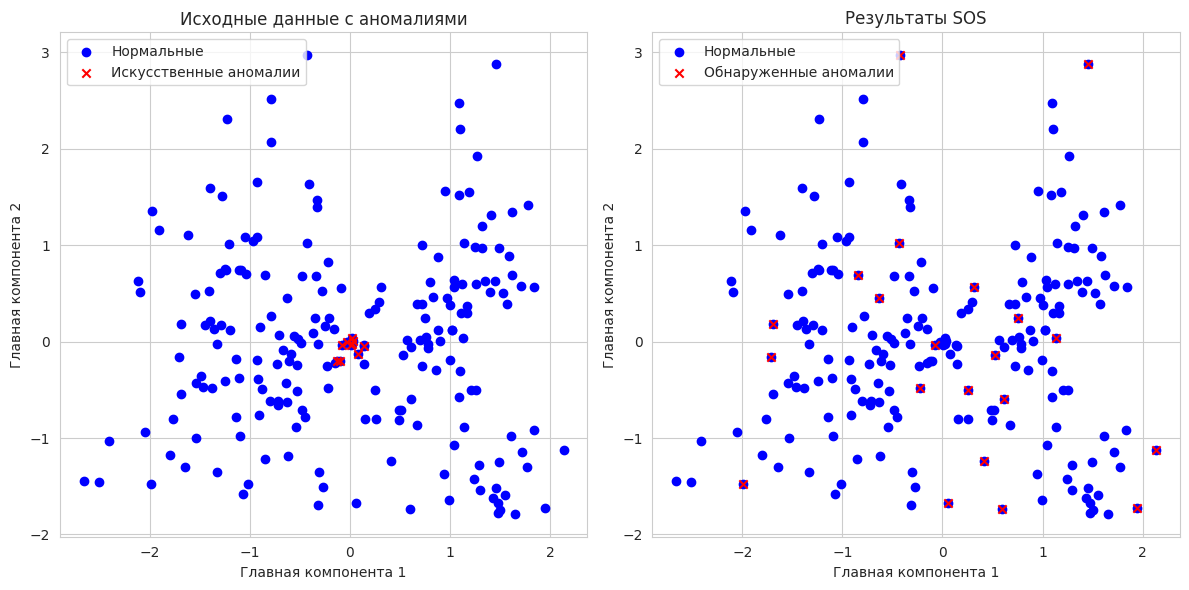

SOS ROC:0.5, precision @ rank n:0.0


In [85]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from pyod.models.sos import SOS
from pyod.utils.data import evaluate_print

X = preprocessor.fit_transform(df)

# Создаем и добавляем искусственные аномалии
np.random.seed(42)
n_samples, n_features = X.shape
n_anomalies = 10
anomalies = np.random.normal(0, 0.1, (n_anomalies, n_features))
X_with_anomalies = np.vstack([X, anomalies])

# Уменьшаем размерность с помощью PCA для визуализации
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_with_anomalies)

# Создаем метки для "нормальных" и "аномальных" объектов
y_true = np.zeros(n_samples + n_anomalies)
y_true[-n_anomalies:] = 1  # Последние n_anomalies объектов считаем аномалиями

# Обучаем модель SOS
sos = SOS()
sos.fit(X_pca)

# Предсказываем аномалии
y_pred = sos.predict(X_pca)

# Визуализируем данные и результаты
plt.figure(figsize=(12, 6))

# Визуализируем исходные данные
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue', marker='o', label='Нормальные')
plt.scatter(X_pca[-n_anomalies:, 0], X_pca[-n_anomalies:, 1], c='red', marker='x', label='Искусственные аномалии')
plt.title('Исходные данные с аномалиями')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.legend()

# Визуализируем обнаруженные аномалии
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue', marker='o', label='Нормальные')
plt.scatter(X_pca[y_pred == 1][:, 0], X_pca[y_pred == 1][:, 1], c='red', marker='x', label='Обнаруженные аномалии')
plt.title('Результаты SOS')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.legend()

plt.tight_layout()
plt.show()

# Оцениваем производительность метода
evaluate_print('SOS', y_true, y_pred)